In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
batchSize= 32
imgSize= 256
rgbChannels= 3
EPOCHS= 10

In [23]:
datasets= tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets/image_segmentation/leukema/",
    seed= 128,
    shuffle= True,
    image_size= (imgSize, imgSize),
    batch_size= batchSize
)

Found 4572 files belonging to 2 classes.


In [24]:
clsNames= datasets.class_names
clsNames

['0', '1']

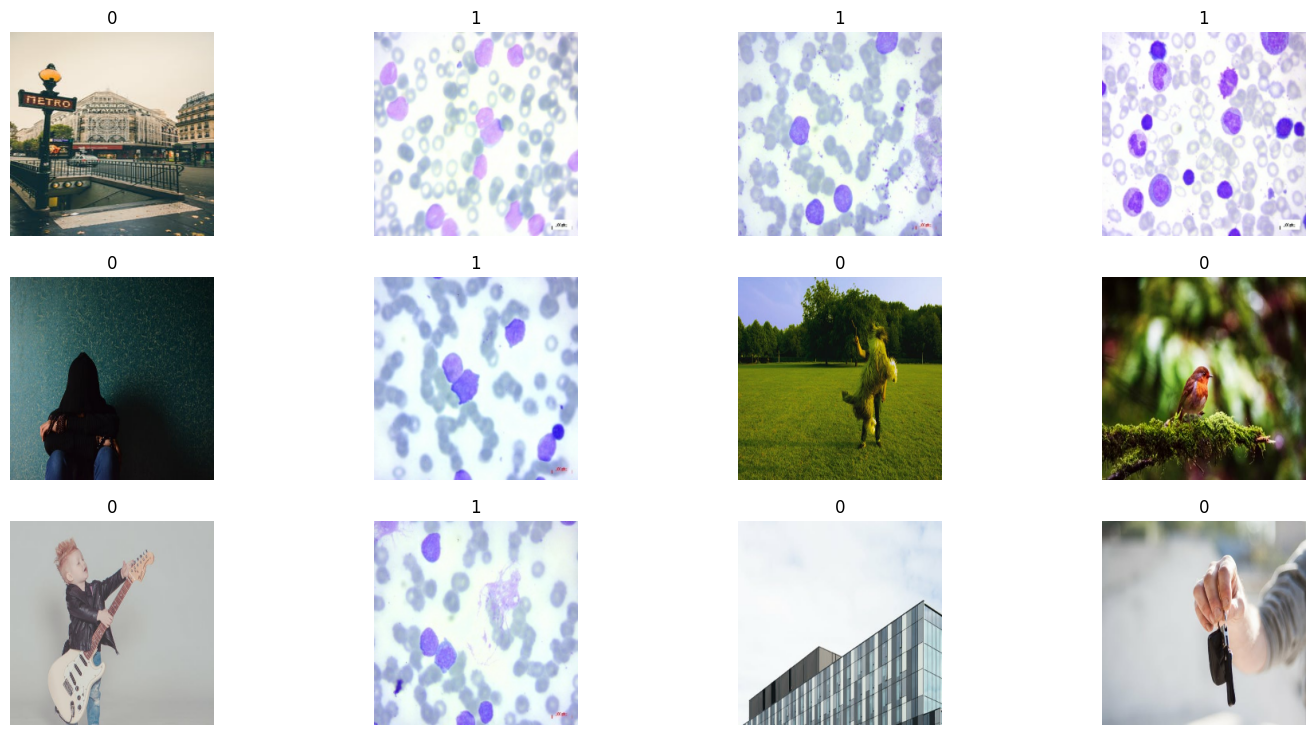

In [25]:
plt.figure(figsize= (18, 9))
for imageBatch, labelBatch in datasets.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(imageBatch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labelBatch[i]])
        plt.axis("off")

In [26]:
def getSplittedDS(ds, trainSplit= 0.8, testSplit= 0.1, valSplit= 0.1, shuffle= True, shuffleSize= 10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    dsSize= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffleSize, seed= 12)
        
    trainSize= int(trainSplit*dsSize)
    valSize= int(valSplit*dsSize)
    
    trainDS= ds.take(trainSize)
    valDS= ds.skip(trainSize).take(valSize)
    testDS= ds.skip(trainSize).skip(valSize)
    
    return trainDS, valDS, testDS

In [27]:
trainDS, valDS, testDS= getSplittedDS(datasets)

In [28]:
len(datasets)

143

In [29]:
trainDS= trainDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
testDS= testDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valDS= valDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [30]:
dataAugmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [31]:
resizeRescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgSize, imgSize),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [32]:
trainDS= trainDS.map(lambda x, y: (dataAugmentation(x, training= True), y)).prefetch(buffer_size= tf.data.AUTOTUNE)

In [13]:
inpShape= batchSize, imgSize, imgSize, rgbChannels

model= models.Sequential([
    resizeRescale,
    layers.Conv2D(32, (3, 3), activation= 'relu', input_shape= (inpShape)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(32, activation= 'relu'),
    layers.Dense(2, activation= 'softmax')
])

model.build(input_shape= inpShape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [15]:
early_stop= tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3)

In [16]:
model.compile(optimizer= 'adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics= ['accuracy'])

In [33]:
history= model.fit(trainDS, validation_data= valDS, verbose= 1, epochs= 75, callbacks=[early_stop])

Epoch 1/75
114/114 [==============================] - 59s 431ms/step - loss: 0.0212 - accuracy: 0.9973 - val_loss: 0.0134 - val_accuracy: 0.9977
Epoch 2/75
114/114 [==============================] - 19s 167ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0101 - val_accuracy: 0.9955
Epoch 3/75
114/114 [==============================] - 20s 174ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.0055 - val_accuracy: 0.9977
Epoch 4/75
114/114 [==============================] - 20s 176ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0058 - val_accuracy: 0.9977
Epoch 5/75
114/114 [==============================] - 20s 177ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0075 - val_accuracy: 0.9977
Epoch 6/75
114/114 [==============================] - 20s 178ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0093 - val_accuracy: 0.9955


In [18]:
score= model.evaluate(testDS.take(1))

1/1 [==============================] - 51s 51s/step - loss: 0.0045 - accuracy: 1.0000


In [19]:
acc= history.history['accuracy']
valAccuracy= history.history['val_accuracy']

loss= history.history['loss']
valLoss= history.history['val_loss']

ValueError: All arrays must be of the same length

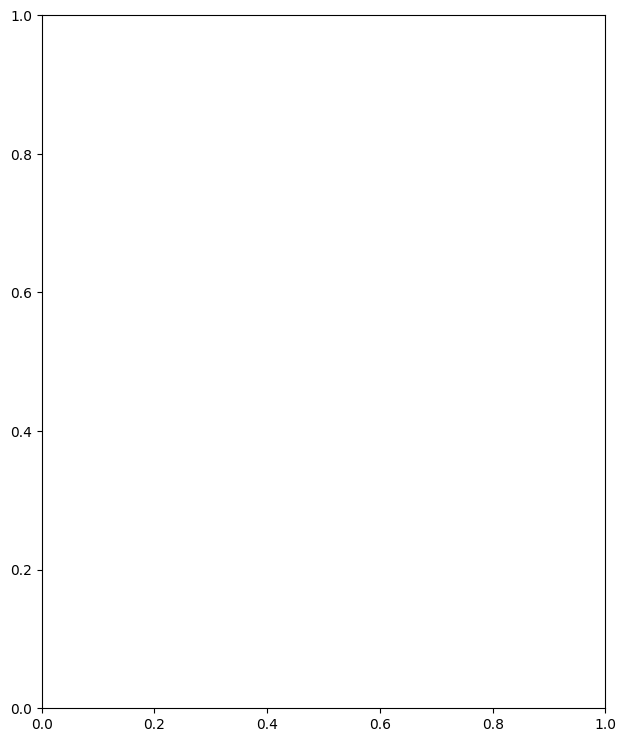

In [20]:
plt.figure(figsize= (16, 9))
plt.subplot(1, 2, 1)
sns.lineplot(x= range(4), y=acc, label= 'Training Accuracy')
plt.title('Training vs Validation Accuracy')
sns.lineplot(x= range(4), y=valAccuracy, label= 'Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x= range(4), y=loss, label= 'Training Loss')
plt.title('Training vs Validation Loss')
sns.lineplot(x= range(4), y=valLoss, label= 'Validation Loss')
plt.legend()
plt.show()

In [18]:
def predFunc(model, img):
    imgArray= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imgArray= tf.expand_dims(imgArray, 0)
    
    predictions= model.predict(imgArray)
    
    predictedClass= clsNames[np.argmax(predictions[0])]
    confidence= round((100*(np.max(predictions[0]))), 2)
    
    return predictedClass, confidence

In [ ]:
plt.figure(figsize= (16, 24))

for images, labels in testDS.take(1):
    for i in range(15):
        ax= plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predictedCls, confidence= predFunc(model, images[i].numpy())
        actualCls= clsNames[labels[i]]
                
        plt.title(f"Actual label: {actualCls} \n Predicted Label: {predictedCls} \n Confidence score: {confidence}%")        
        plt.axis('off')

: 

In [35]:
actual_lbl=[]
pred_lbl=[]
for cycle in range(20):
    print("starting cycle: ", cycle)
    for images, labels in testDS.take(1):
        for i in range(8):
            predictedCls, confidence= predFunc(model, images[i].numpy())
            actualCls= clsNames[labels[i]]

            actual_lbl.append(actualCls)
            pred_lbl.append(predictedCls)
    print("-----------------")

starting cycle:  0
1/1 [==============================] - 0s 30ms/step
-----------------
starting cycle:  1
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  2
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  3
1/1 [==============================] - 0s 23ms/step
-----------------
starting cycle:  4
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  5
1/1 [==============================] - 0s 33ms/step
-----------------
starting cycle:  6
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  7
1/1 [==============================] - 0s 33ms/step
-----------------
starting cycle:  8
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  9
1/1 [==============================] - 0s 34ms/step
-----------------
starting cycle:  10
1/1 [==============================] - 0s 25ms/step
-----------------
starting cycle:  11


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm= confusion_matrix(actual_lbl, pred_lbl)
cm

array([[76,  0],
       [ 0, 84]], dtype=int64)

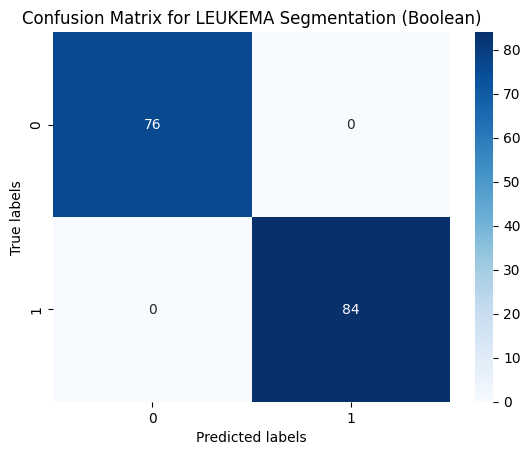

In [38]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix for LEUKEMA Segmentation (Boolean)')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
#98.93% accuracy

In [34]:
converter= tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

with open('../exports/leukema_segmentationV1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmp6uccazi8\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmp6uccazi8\assets
